- **Nombre del candidato:** José Fernando Pamplona Zuluaga
- **Fecha:** 18 de octubre de 2022
- **Email de contacto:** pamplonazfernando@gmail.com

### Introducción

El equipo de Moderaciones IT (ModIT) dentro de Mercado Libre, se encarga de bloquear productos del marketplace que infringen políticas como derechos de autor, derechos de marca o aquellos cuyas imágenes no cumplen ciertos estándares de calidad. Estas bajas o moderaciones se pueden realizar manualmente o de forma automática, esta última siempre apoyada por modelos de Machine Learning que toman decisiones con base en los atributos (precio, marca, título, descripción, etc) y/o las imágenes de los productos.

Debido a que Mercado Libre tiene como prioridad en el 2022 el segmento de moda, ModIT está analizando todos los productos nuevos dentro del segmento de moda con el fin de moderar aquellos cuya imagen de portada no presente el producto en un fondo plano en color blanco o crema. Teniendo en cuenta que este trabajo está siendo realizado de forma manual por un equipo de 10 personas (moderadores) el análisis de ítems se limita a un total de 4,000 diarios. 

Ante esto nuestro equipo decide aceptar el reto y disparar un proceso de experimentación para identificar si podríamos o no generar algún recurso que apoye al equipo ModIT para automatizar el proceso y agregar valor a la experiencia laboral de los moderadores. 

A continuación te presentaremos 3 tareas comunes que nos enfrentamos como equipo al momento proponer una solución a algún problema planteado, para resolver cada una de ellas ten en cuenta los siguientes puntos:

1. Siéntete libre de realizar preguntas ante cualquier duda que se te presente. Estamos a un correo de distancia.
2. Los experimentos que realices deben ser replicables. Asegúrate de dejar disponible todo lo necesario para que podamos ejecutar tu código. Puedes usar archivos auxiliares como archivo de dependencias o scripts con funciones o clases.
3. Es importante que documentes lo que más puedas de tu código y dejes plasmado todas las ideas, procesos, experimentos, hipótesis y/o conclusiones que tuviste mientras estabas resolviendo el problema.
4. No esperamos una solución perfecta, para nosotros es más importante el proceso que planteas que el performance de la solución.

Mucha suerte!

### Parte I

Para el proceso de experimentación ModIT nos envía un archivo CSV (`training_data.csv`) con las siguientes columnas:
- **item_id:** Identificador único de item dentro del marketplace.
- **site_id:** País al que pertenece el ítem.
- **domain_id:** Categoría del marketplace a la que pertenece el ítem.
- **picture_id:** Identificador único de la imagen de portada del ítem. Con el *picture_id* podrás construir una url para descargar cada imagen, la estructura es la siguiente: https://http2.mlstatic.com/D_{picture_id}-F.jpg, e.g. http://http2.mlstatic.com/D_680853-MLM50014173158_052022-F.jpg
- **correct_background?:** 1 si el producto se presenta en un fondo apropiado, 0 de lo contrario.

En esta sección se requiere que realices los experimentos necesarios que permitan responder sí podemos o no dar solución al problema. 

In [1]:
# Con el fin de tener el acceso a una GPU en la posibilidad de agilizar los 
# entrenamientos que se realizen, se elige google colab para ejecutar este 
# cuaderno, y se usara google drive para guardar los archivos necesarios
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
cd /content/drive/MyDrive/Proyectos visión artificial/MELI_CVC_20220719_tech_test

/content/drive/MyDrive/Proyectos visión artificial/MELI_CVC_20220719_tech_test


**Pensamientos iniciales**

Como primer abordaje se analizará la base de datos explorando la variedad de las imágenes.
En pro de obtener la mejor relación desempeño/costo computacional se imaginan algunas hipótesis de soluciones con diversidad de técnicas desde la visión artificial, el machine learning y deep learning (de la más simple a la más compleja):


1.   Segmentación por umbral y analisis de areas
2.   Segmentación por color en diversos espacios de color con extracción de características morfológicas y de posición para clasificacion (NN, SVM o Random Forest)
3.   Análisis de color con Clustering
4.   Clasificación con CNN
5.   Segmentación semántica del fondo y análisis de color y textura en esta

Como base para el proyecto se toma como referencia una plantilla de Sergios Karagiannakos([Enlace](https://github.com/SergiosKar/Keras-Project-Template/blob/master/utils/args.py))

En esta estructura se irán creando las clases y funciones necesarias que se usarán en este cuaderno. Pro lo pronto iniciaremos con un análisis de la base de datos de entrenamiento.

In [3]:
from data_loader.meli_data_loader import Meli_fashion_data_set

# Exploring the dataset
meli_data_set = Meli_fashion_data_set("training_data.csv")
meli_data_set.print_data_categories()

# of backgorund_types:  3
1    1863
0    1839
?     670 

# of site_ids:  3
MLB    1589
MLA    1440
MLM    1343 

# of product_types:  28
JACKETS_AND_COATS                   827
T_SHIRTS                            821
SNEAKERS                            703
PANTS                               339
SWEATSHIRTS_AND_HOODIES             244
SHIRTS                              200
BOOTS_AND_BOOTIES                   196
LOAFERS_AND_OXFORDS                 195
BLOUSES                             182
SHORTS                              128
HEELS_AND_WEDGES                    123
SWEATERS_AND_CARDIGANS               95
AUTOMOTIVE_SKIRTS                    69
LEGGINGS                             56
SWIMWEAR                             44
SPORT_T_SHIRTS                       36
FOOTBALL_SHOES                       25
SPORT_SHORTS                         19
SPORT_PANTS                          16
UNDERPANTS                           15
PET_JACKETS_AND_COATS                 9
BABY_SWIMWEAR         

En el resultado anterior se identifican 3 clases adicionando 670 ejemplos etiquetados con '?' que (según se habló con Fleipe Molina) son los ejemplos en los que el provehedor de etiquetado tenia alguna duda. 

También podemos ver que los productos en el dataset provienen de 3 paises diferentes y que estàn clasificados en 28 categorías de productos diferentes. Éste ultimo dato puede ser de ayuda si se implementa una solución con segmentación semántica.

Veamos que tipos de imágenes tiene la base de datos.

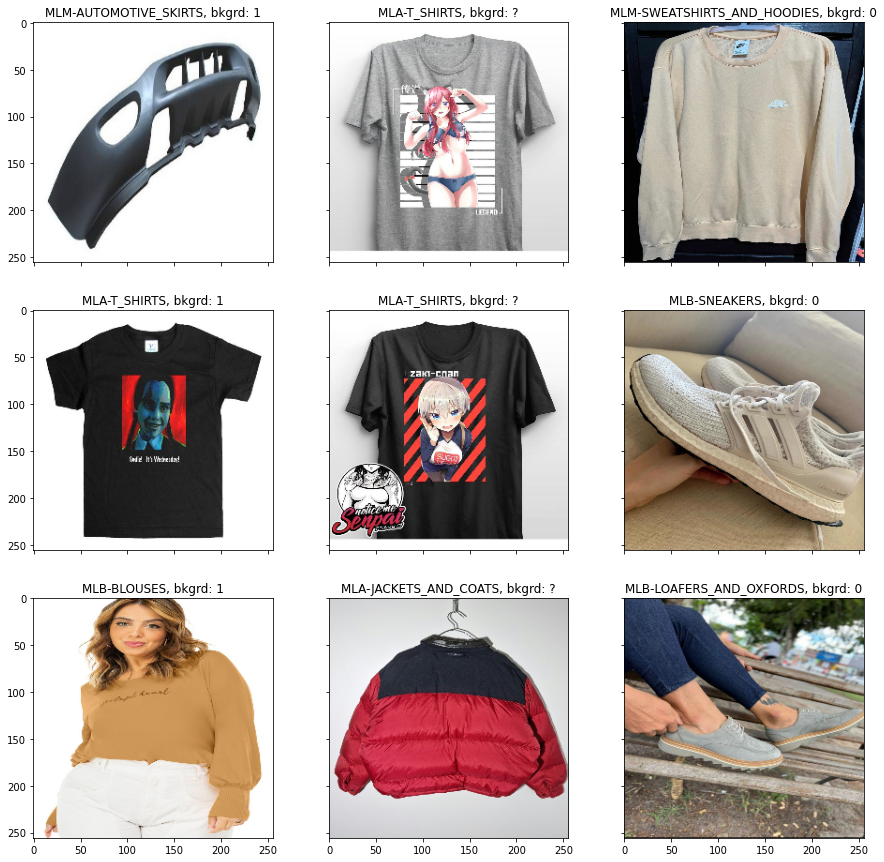

In [4]:
meli_data_set.explore_dataset(seed=8)

Al explorar el dataset podemos verificar que hay una diferencia grande entre los fondos de las imágenes etiquetadas como 1 y como 0. y que aunque hay varias imágenes con la etiqueta '?' que podrían ser etiquetadas como '1', las que están màs hacia el lado del '0' es dificil definir esa frontera. Por esto se decide dejar fuera estas muestras por ahora y tal vez tenerlas en cuenta para mas adelante.

Una observación adicional es que en general los tipos de producto están bien etiquetados (a exepcion de algunas auto-partes en la categoría AUTOMOTIVE_SKIRTS que se pueden filtrar). Aunque en principio no lo parece, ésta columna (domain_id) y site_id podrían aportar a la solución del problema, pero primero se verá desde las características de la imágen.

Finalmente al observar que los fondos aun siendo del color correcto y planos pueden ser rechazados por su textura, se descartan la hipótesis 3 y se unifican las propuestas 1 y 2 adicionando características de textura y es inevitable un análisis con CNN. La hipotesis 5, segmentación semántica, siguie siendo una opcion, pero podría necesitar un proceso de etiquetado (veremos más adelante).

El primer experimento constará de una extracción de características llevando a cabo los siguientes pasos:

1. **umbralizar** (thresholding): Dado que el fondo es notablemente claro en las imágenes positivas, la umbralización permitirá ocultar características de las zonas que no interesan para el problema (como el producto). el valor de threshold se eligirá un valor global para la imágen que puede ser optimizable como hyperparámetro (el umbral adaptativo es ta pensado para dar uniformidad al fondo).
2. **Obtener características de color**: Para esto se utilizará el espacio de color HSV donde usaremos como características histogramas del tono (HUE: 15 características) y la intensidad(Value: 12 características). Se busca dar cumplimiento a la característica de fondo blanco o crema.
3. **Obtener caracteristicas morfológicas del fondo**: Se piensa en adquirir el area realativa del fondo (sum(intensidades)/area imagen) y su centro de masa, pero dado que la mayoria de los objetos están centrados, la mayoria de estos estarían cerca al centro de la imágen. Para que estas características se propone lo siguiente:

      *   Dividir la imagen en 4 (mitad superior, mitad inferior, mitad derecha u mitad izquierda), así la ubicación del centro de masa del fondo puede mostrar una tendencia a acercarse a los bordes.(el centro de masa se hace relativo al tamaño de la imágen)
      *   Extraer área erlativa y centros de masa(en 'x' y en 'y') a cada una de las subdivisiones obteniendo 12 características morfológicas

4. **Obtener Caracterísitcas de textura**: Se usa la libreria mahotas para extraer 13 de las 14 caracteristicas de Haralick en los 4 ángulos posibles (52 características)

con estas características se crea un nuevo dataset con el fin de manipularlo facilmente sin un pipeline muy complejo en el entrenamiento. El dataset se crea con el script **'create_featured_dataset.py'** en la raiz del proyecto.

El dataset esta también en la raliz del proyecto como 'features_dataset.csv' a contoniuación se presenta un análisis de estas características:

Clasification accuracy:  94.5945945945946 %


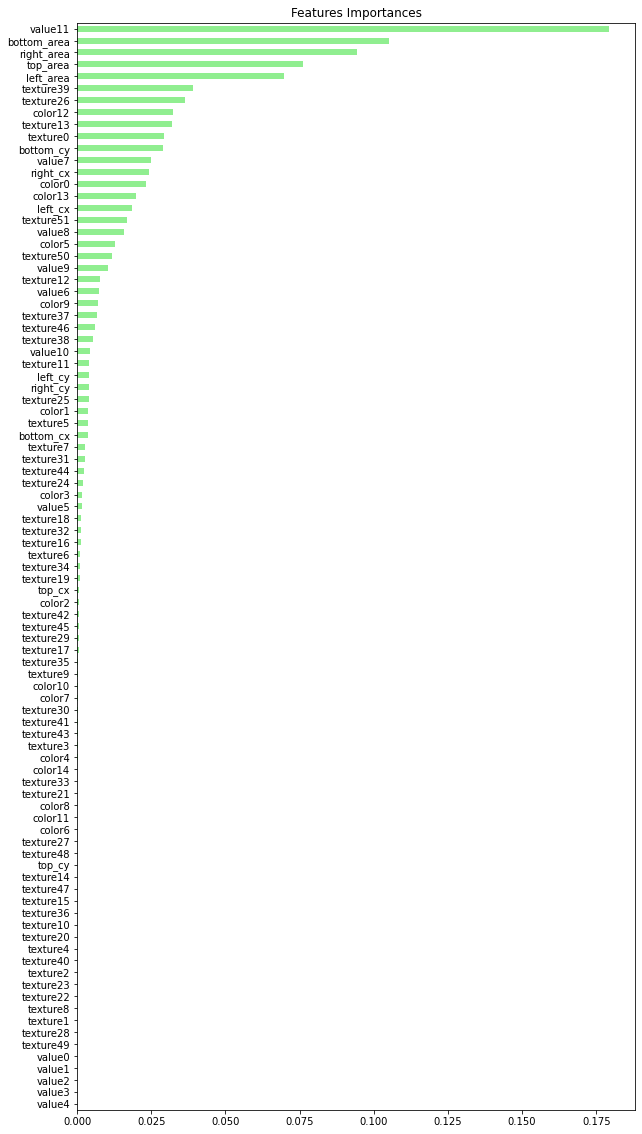

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd

random_seed = 1
image_features_df = pd.read_csv('features_dataset.csv')

features = image_features_df.drop('label', axis=1).astype(float)
labels = image_features_df['label'].astype(bool)

x_train, x_test, y_train, y_test = train_test_split(features, labels, 
                                                    test_size=0.3, 
                                                    random_state=random_seed)

rf_model = RandomForestClassifier(n_estimators=100, 
                                  min_samples_leaf=0.05, 
                                  random_state=random_seed)

rf_model.fit(x_train, y_train)
y_pred = rf_model.predict(x_test)
print('Clasification accuracy: ', accuracy_score(y_test, y_pred)*100, '%')

importances = pd.Series(data=rf_model.feature_importances_,
                        index= x_train.columns)
importances_sorted = importances.sort_values()
importances_sorted.plot(kind='barh', color='lightgreen', figsize=(10, 20))
plt.title('Features Importances')
plt.show()

En el resultado anterior podemos ver que las características extraidas nos permiten obtener un 94.6% con los parámetros establecidos y nos muestra la importancia de cada una de las caracterísitcas en este resultado.

Asi podremos definir que las características más importantes son la alta intensidad (value) del fondo y el área que este ocupa. Luego vemos la importancia del segundo momento angular de Haralick (texture0, 13, 16 y 39) y despues otros descriptores de color, atlta intensidad, textura y posición.

vemos que los valores bajos de intensidad no aportan mucho en este caso y muchas de las características de textura pueden ser descartadas.

In [6]:
from trainers.classic_trainer import ClasicKfoldCrossValidationTrainer
from configs.classic_trainer_config import get_grid_search_parámeters

purged_feature = features[importances_sorted[38:].index]

multimodels_trainer =  ClasicKfoldCrossValidationTrainer(None, 
                                (purged_feature, labels),
                                get_grid_search_parámeters(seed = random_seed), 
                                splits=5,
                                seed = random_seed)
multimodels_trainer.train()

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

In [7]:
from sklearn.metrics import classification_report
import pickle
print("Tuned Parameters: {}".format(multimodels_trainer.params))
model_location = 'experiments/num_features/best_model_feature_cls.sav'
multimodels_trainer.best_model_save(model_location)
labels_predictions = pickle.load(open(model_location, 'rb')).predict(purged_feature)
print(classification_report(labels, labels_predictions))

Tuned Parameters: {'model__estimator': RandomForestClassifier(criterion='entropy', max_features='sqrt',
                       min_samples_leaf=0.001, n_estimators=50, random_state=1), 'model__estimator__criterion': 'entropy', 'model__estimator__max_features': 'sqrt', 'model__estimator__min_samples_leaf': 0.001, 'model__estimator__n_estimators': 50, 'model__estimator__random_state': 1}
              precision    recall  f1-score   support

       False       0.98      0.98      0.98      1837
        True       0.98      0.98      0.98      1863

    accuracy                           0.98      3700
   macro avg       0.98      0.98      0.98      3700
weighted avg       0.98      0.98      0.98      3700



Los resultados sobre este dataset se ven sorprendentes y aun con cossvalidation la metrica de accurací está sobre el 96%. dado esto se mirará que puede hacer un modelo convolucional dada la base de datos con imágenens. Para construir el pipeline de la base de datos se usó la clase de Tensor Flow, tf.data y tf.keras para la construcción del modelo.

In [2]:
!pip install dotmap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from models.conv_meli_fashion_model import ConvMeliFashionModel
from data_loader.meli_data_loader import MeliDataLoader
from trainers.conv_trainer import ConvModelTrainer
from utils.config import process_config
from utils.dirs import create_dirs

config = process_config("configs/meli_fashion_config.json")
create_dirs([config.callbacks.tensorboard_log_dir, config.callbacks.checkpoint_dir])
data_loader = MeliDataLoader(config)
model = ConvMeliFashionModel(config).model
# model.summary()
trainer = ConvModelTrainer(model, data_loader.get_train_test_data(), config)
trainer.train()

Epoch 1/20
10/10 [==============================] - ETA: 0s - loss: 0.6409 - accuracy: 0.6530 
Epoch 1: val_loss improved from inf to 0.51074, saving model to experiments/2022-10-17/Meli_moda/checkpoints/Meli_moda-01-0.51.hdf5
10/10 [==============================] - 430s 42s/step - loss: 0.6409 - accuracy: 0.6530 - val_loss: 0.5107 - val_accuracy: 0.7930
Epoch 2/20
10/10 [==============================] - ETA: 0s - loss: 0.4052 - accuracy: 0.8703 
Epoch 2: val_loss improved from 0.51074 to 0.30038, saving model to experiments/2022-10-17/Meli_moda/checkpoints/Meli_moda-02-0.30.hdf5
10/10 [==============================] - 389s 40s/step - loss: 0.4052 - accuracy: 0.8703 - val_loss: 0.3004 - val_accuracy: 0.8750
Epoch 3/20
10/10 [==============================] - ETA: 0s - loss: 0.2934 - accuracy: 0.9023 
Epoch 3: val_loss improved from 0.30038 to 0.25210, saving model to experiments/2022-10-17/Meli_moda/checkpoints/Meli_moda-03-0.25.hdf5
10/10 [==============================] - 409s 42s

KeyError: ignored

NameError: ignored

### Parte II

Con el fin de evaluar la solución, se nos hace llegar un nuevo dataset (`productive_data.csv`) con los últimos 5,800 ítems revisados por el equipo de moderadores. La idea en esta parte es que realices una evaluación de tu propuesta y nos hagas saber si estaría lista para puesta en producción. **Nota:** Recuerda que en Mercado Libre trabajamos codo a codo para alcanzar nuestros objetivos así que cualquier duda o solicitud con gusto será atendida por tus compañeros de equipo o stakeholders.

### Parte III

Debido al gran volumen de ítems que procesamos día a día, algún error en nuestras soluciones podría llegar a afectar muchos vendedores y generar malas experiencias de usuario en el marketplace. Con lo cual, solemos penalizar bastante los errores de clasificación que involucren bajas erróneas de ítems. Como última tarea, te proponemos plantear un proceso que nos permita maximizar la precisión de tu solución con base a los datos que tienes disponibles hasta el momento.